In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [2]:
region = 'CONUS'
date = 'July08v1dt'

xlab = 'Number of years of input data'

norm = {
    'ERCOT' : 26308, # Mean demand (MW) for file ERCOT_demand_synthetic_1950-2020_MEM.csv
    'CONUS' : 303461, # Mean demand (MW) for file CONUS_demand_synthetic_1950-2020_MEM.csv
}

title_map = {
    'SWB' : 'Solar + wind + battery',
    'SWBNG' : 'Solar + wind + battery + natural gas',
    'SWBPGP' : 'Solar + wind + '+r'battery + H$_{2}$'
}
title_map2 = {
    'SWB' : 'Solar + wind + battery',
    'SWBNG' : 'Solar + wind +\nbattery + natural gas',
    'SWBPGP' : 'Solar + wind +\n'+r'battery + H$_{2}$'
}

# Map for each nYrs value to downselect how many systems to plot for equal comparison
max_iters = {
    'SWB' : {
        1 : 100,
        3 : 100,
        5 : 100,
        10 : 50,
    },
    'SWBNG' : {
        1 : 100,
        3 : 100,
        5 : 100,
        10 : 50,
    },
    'SWBPGP' : {
        1 : 100,
        3 : 100,
        5 : 100,
        10 : 50,
    }
}

In [3]:
# n_years_July08v1dt1_CONUS_SWBPGP_NEW.csv

def agg_df(region, date, techs, verbose=True):
    files = glob(f"delta_t_comp/n_years_{date}*_{region}_{techs}_NEW.csv")
    for i, f_name in enumerate(files):
        dt = int(f_name.split('/')[-1].split('_')[2].replace(date,''))
        if i == 0:
            df = pd.read_csv(f_name)
            df['deltaT'] = [dt] * len(df.index)
        else:
            tmp = pd.read_csv(f_name)
            tmp['deltaT'] = [dt] * len(tmp.index)
            df = pd.concat([df, tmp])
    
    df = df.sort_values(by=['deltaT', 'n_years'])
    if verbose:
        print(techs)
        for DT in df['deltaT'].unique():
            print(f" - deltaT = {DT}")
            for NYRS in df['n_years'].unique():
                df2 = df[ (df['deltaT'] == DT) & (df['n_years'] == NYRS) ]
                df3 = df2[ df2['iter'] < max_iters[techs][NYRS] ]
                #print(f" --- {NYRS} has {len(df2.index)} originally, downselecting to {len(df3.index)}")
                
    
    return df

SWB
 - deltaT = 1
 - deltaT = 2
 - deltaT = 3
 - deltaT = 4
wind capacity
1, [632.4415438193839, 685.1380635673606, 700.4523103185863, 704.6654190386913]
2, [617.9060795881325, 664.909098082736, 680.2586394912039, 692.2454786446874]
3, [631.879419017675, 685.4911690144737, 694.0371991594368, 686.5004460241116]
4, [634.2126314834248, 667.5706638253502, 684.0441487503989, 680.6907089275454]
solar capacity
1, [258.0924032088139, 280.3398241308261, 284.329296812201, 302.2837798706458]
2, [265.29501472327075, 291.3674439933467, 296.8701251772268, 310.95353327171773]
3, [259.98495105938457, 282.39494511068096, 290.0657803617936, 312.71487666535995]
4, [256.97603908593635, 287.09351296793807, 291.7335977644003, 314.4631545310179]
storage capacity
1, [7.569999417785186, 8.387303102202768, 9.04045908636764, 9.92678823993383]
2, [7.559806036246306, 8.371842550511904, 8.986512005632179, 9.660126878973495]
3, [7.321842616885674, 8.133875451627459, 8.8708895105559, 9.857599820137677]
4, [7.19391681

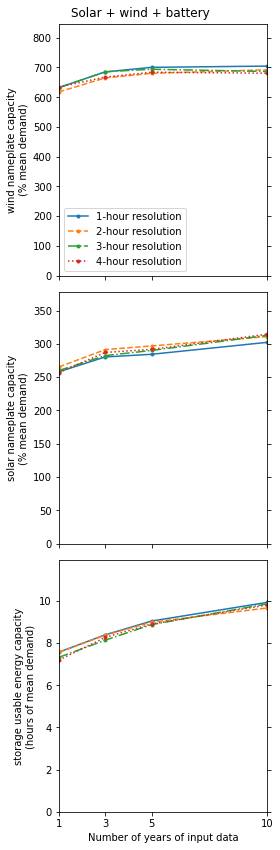

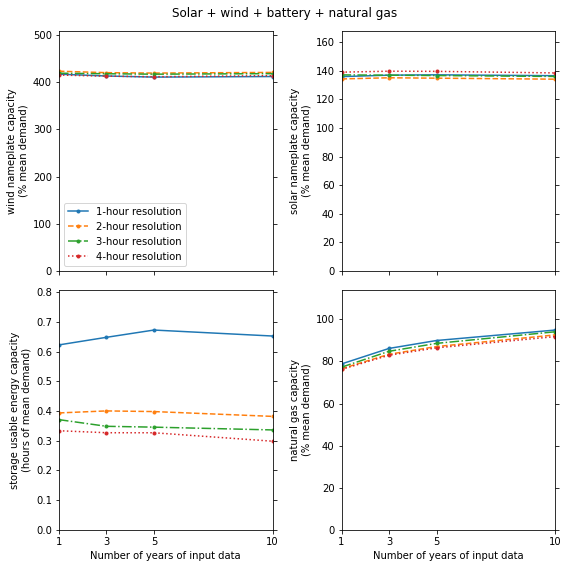

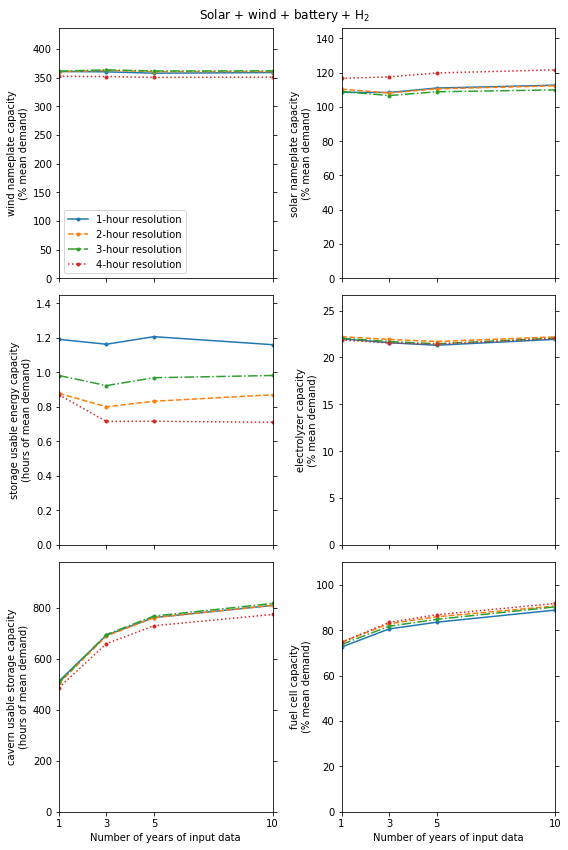

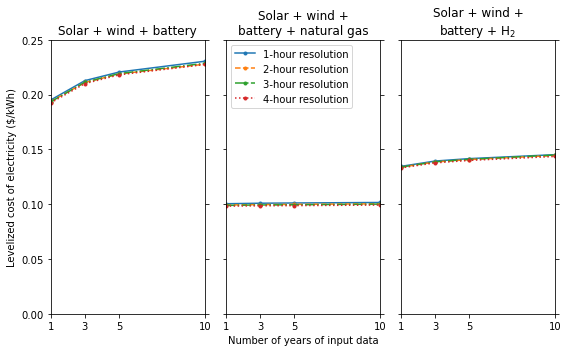

In [4]:
def caps_and_labs(techs):
    caps = []
    labs = []
    
    caps.append('wind capacity')
    caps.append('solar capacity')
    caps.append('storage capacity')
    labs.append('wind nameplate capacity\n(% mean demand)')
    labs.append('solar nameplate capacity\n(% mean demand)')
    labs.append('storage usable energy capacity\n(hours of mean demand)')

    if 'PGP' in techs:
        caps.append('to_PGP capacity')
        caps.append('PGP_storage capacity')
        caps.append('from_PGP capacity')
        labs.append('electrolyzer capacity\n(% mean demand)')
        labs.append('cavern usable storage capacity\n(hours of mean demand)')
        labs.append('fuel cell capacity\n(% mean demand)')
   
    if 'NG' in techs:
        caps.append('natgas capacity')
        labs.append('natural gas capacity\n(% mean demand)')
    
    return caps, labs


def plot_capacities(df, techs):
    
    nYrs = df['n_years'].unique()
    yrs_labs = ['1', '3', '5', '10']
    caps, labs = caps_and_labs(techs)
    row_and_col = {
        'SWB' : [3, 1],
        'SWBNG' : [2, 2],
        'SWBPGP' : [3, 2]
    }
    
    ROWS, COLS = row_and_col[techs]
    fig, AXS = plt.subplots(nrows=ROWS, ncols=COLS, 
                            sharex=True, figsize=(4*COLS, 4*ROWS))

    axs = AXS.ravel()
    
    styles = ['-', '--', '-.', ':']
    for i, (cap, lab) in enumerate(zip(caps, labs)):
        print(cap)
        denom = norm[region]
        if 'cavern' in cap:
            denom = denom * 0.7 # Fuel cell efficiency so we convert to usable energy
        elif 'storage' in cap:
            denom = denom
        else:
            denom = denom / 100
        MAX = 0
        dt_1_nYrs_1 = 0
        dt_1_nYrs_10 = 0
        for j, DT in enumerate(df['deltaT'].unique()):
            dt_x_nYrs_1 = 0
            dt_x_nYrs_10 = 0
            vals = []
            for NYRS in df['n_years'].unique():
                df2 = df[ (df['deltaT'] == DT) & (df['n_years'] == NYRS) ]
                vals.append(np.mean(df2[cap]) / denom)
                if NYRS == 1:
                    dt_x_nYrs_1 = vals[-1]
                if NYRS == 10:
                    dt_x_nYrs_10 = vals[-1]
                if NYRS == 1 and DT == 1:
                    dt_1_nYrs_1 = vals[-1]
                if NYRS == 10 and DT == 1:
                    dt_1_nYrs_10 = vals[-1]
            axs[i].plot(nYrs, vals, marker='.', ls=styles[j], label=f"{DT}-hour resolution")
            if np.max(vals) > MAX:
                MAX = np.max(vals)
            d1 = vals[0]/dt_1_nYrs_1*100
            d10 = vals[-1]/dt_1_nYrs_10*100
            dd = d10 - d1
            d10_scaled = vals[-1]/dt_1_nYrs_10*100 / d1
            #print(f"{DT}, {d1:.1f}%, {d10:.1f}%, {dd:.1f}%, {d10_scaled:.3f}")
            print(f"{DT}, {vals}")
        axs[i].set_ylabel(lab)
        axs[i].set_ylim(0, MAX*1.2)
        axs[i].set_xlim(1, 10)
        axs[i].set_xticks(nYrs)
        axs[i].set_xticklabels(yrs_labs)
        axs[i].tick_params(right=True)
    
    for col in range(COLS):
        axs[len(axs) - col - 1 ].set_xlabel(xlab)
    axs[0].legend(loc='lower left')
    plt.suptitle(title_map[techs])
    plt.tight_layout()
    plt.savefig(f"plots/si_fig_deltaT_comp_caps_{techs}.png")
    return


def plot_costs(dfs):
    
    nYrs = [1, 3, 5, 10]
    yrs_labs = ['1', '3', '5', '10']
    
    fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(8, 5))
    
    styles = ['-', '--', '-.', ':']
    denom = norm[region]
    for i, (techs, df) in enumerate(dfs.items()):
        
        MAX = 0
        dt_1_nYrs_1 = 0
        for j, DT in enumerate(df['deltaT'].unique()):
            vals = []
            for NYRS in df['n_years'].unique():
                df2 = df[ (df['deltaT'] == DT) & (df['n_years'] == NYRS) ]
                vals.append(np.mean(df2['syst_cost']) / denom)
                if NYRS == 1 and DT == 1:
                    dt_1_nYrs_1 = vals[-1]
            axs[i].plot(nYrs, vals, marker='.', ls=styles[j], label=f"{DT}-hour resolution")
            if np.max(vals) > MAX:
                MAX = np.max(vals)
            #print(f"{DT}, {np.array(vals)/dt_1_nYrs_1*100}")
            print(f"{DT}, {vals}")
        axs[i].set_ylim(0, 0.25)
        axs[i].set_xlim(1, 10)
        axs[i].set_xticks(nYrs)
        axs[i].set_xticklabels(yrs_labs)
        axs[i].set_title(title_map2[techs])
        axs[i].tick_params(right=True)
    axs[0].set_ylabel('Levelized cost of electricity ($/kWh)')
    axs[1].set_xlabel(xlab)
    axs[1].legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(f"plots/si_fig_deltaT_comp_costs.png")
    return

dfs = {}
for techs in title_map.keys():
    df = agg_df(region, date, techs)
    plot_capacities(df, techs)
    dfs[techs] = df
plot_costs(dfs)